In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# For Colab: mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Load the dataset
df = pd.read_csv("/content/drive/My Drive/dl-udemy/fake_reg.csv")
print("Data Preview:")
print(df.head())

Mounted at /content/drive/
Data Preview:
        price     feature1     feature2
0  461.527929   999.787558   999.766096
1  548.130011   998.861615  1001.042403
2  410.297162  1000.070267   998.844015
3  540.382220   999.952251  1000.440940
4  546.024553  1000.446011  1000.338531


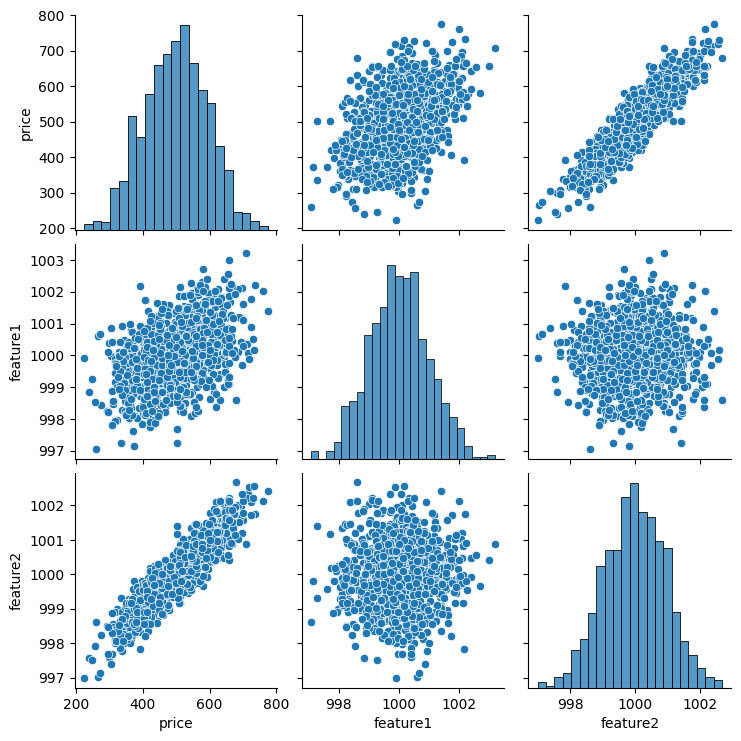

Shapes: (700, 2) (300, 2) (700,) (300,)


In [ ]:
# Exploratory Data Analysis: pairplot of all features
sns.pairplot(df)
plt.show()

# Separate features and target
X = df[['feature1', 'feature2']].values  # features
y = df['price'].values                   # target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# Scale the features using MinMaxScaler (only on features, not the target)
scaler = MinMaxScaler()
scaler.fit(X_train)  # Fit only on training data to avoid data leakage
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler for future use
with open('scaler.sav', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

# Create a TensorDataset and DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network model (architecture matches the Keras version)
model = nn.Sequential(
    nn.Linear(2, 4),   # Input layer: 2 features -> 4 neurons
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1)    # Output layer: 1 neuron for regression prediction
)

# Define the loss function (MSE) and optimizer (RMSprop with a higher LR)
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

# Train the model using mini-batch training
epochs = 250
loss_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()                   # Reset gradients for the batch
        outputs = model(batch_x)                  # Forward pass
        loss = criterion(outputs, batch_y)        # Compute loss
        loss.backward()                           # Backward pass
        optimizer.step()                          # Update weights
        running_loss += loss.item() * batch_x.size(0)

    epoch_loss = running_loss / len(train_dataset)
    loss_history.append(epoch_loss)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [50/250], Loss: 31.0048
Epoch [100/250], Loss: 34.0843
Epoch [150/250], Loss: 49.3958
Epoch [200/250], Loss: 28.3213
Epoch [250/250], Loss: 43.6040


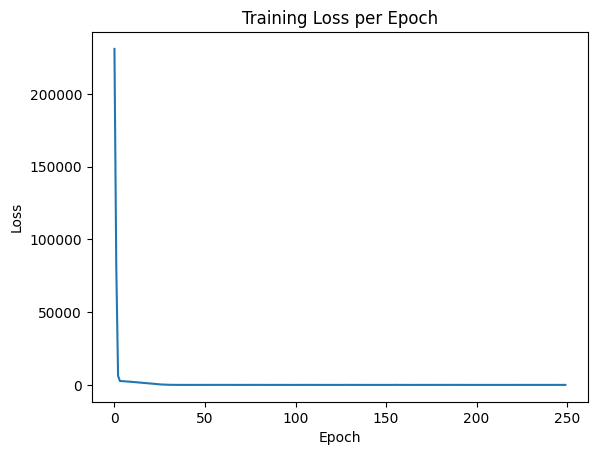

In [ ]:
# Plot training loss per epoch
sns.lineplot(x=range(epochs), y=loss_history)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Evaluate the model on the training and test sets
model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor)
    test_pred = model(X_test_tensor)
    train_loss = criterion(train_pred, y_train_tensor).item()
    test_loss = criterion(test_pred, y_test_tensor).item()

print("Training Loss (MSE):", train_loss)
print("Test Loss (MSE):", test_loss)

Training Loss (MSE): 48.030696868896484
Test Loss (MSE): 54.175201416015625


       Test Y  Model Predictions
0  402.296319         409.555786
1  624.156198         629.954590
2  582.455066         598.231750
3  578.588606         578.149109
4  371.224104         370.526917


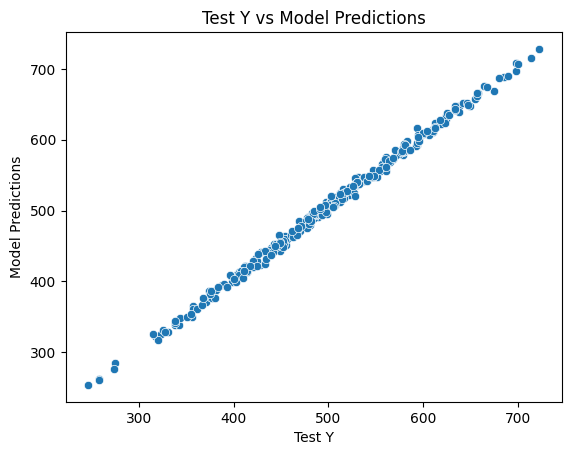

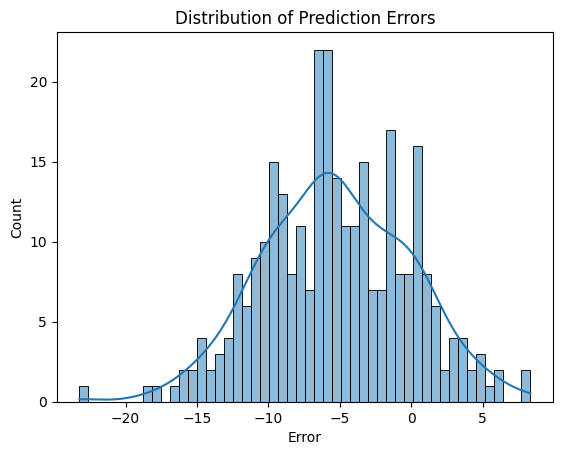

Mean Absolute Error: 6.058538940644361
Mean Squared Error: 54.175199499561096
Root Mean Squared Error: 7.360380390955422


In [ ]:
# Convert predictions to numpy arrays for further analysis
test_predictions = test_pred.numpy().reshape(-1)
# Create a DataFrame comparing actual vs. predicted values
pred_df = pd.DataFrame({'Test Y': y_test, 'Model Predictions': test_predictions})
print(pred_df.head())

# Scatter plot: Actual vs. Predicted values
sns.scatterplot(x='Test Y', y='Model Predictions', data=pred_df)
plt.title("Test Y vs Model Predictions")
plt.show()

# Compute and plot error distribution
pred_df['Error'] = pred_df['Test Y'] - pred_df['Model Predictions']
sns.histplot(pred_df['Error'], bins=50, kde=True)
plt.title("Distribution of Prediction Errors")
plt.show()

# Compute evaluation metrics
mae = mean_absolute_error(pred_df['Test Y'], pred_df['Model Predictions'])
mse = mean_squared_error(pred_df['Test Y'], pred_df['Model Predictions'])
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))

In [ ]:

# Predict on a new data point (remember to scale the features!)
new_gem = np.array([[998, 1000]])
new_gem_scaled = scaler.transform(new_gem)
new_gem_tensor = torch.tensor(new_gem_scaled, dtype=torch.float32)
model_prediction = model(new_gem_tensor).item()
print("Prediction for new sample:", model_prediction)

# Save the model's state dictionary
torch.save(model.state_dict(), 'model.pth')

# To load the model later, define the same architecture and load the state dictionary
loaded_model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1)
)
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model.eval()

# Use the loaded model to predict on the new sample
with torch.no_grad():
    new_prediction = loaded_model(new_gem_tensor).item()
print("Loaded model prediction for new sample:", new_prediction)

Prediction for new sample: 424.1177978515625
Loaded model prediction for new sample: 424.1177978515625
